In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
physical_devices = tf.test.gpu_device_name()
print(physical_devices)

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import datasets

import numpy as np

/device:GPU:0


c:\Users\Tim\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ds_preprocess_image(entity):
    img = entity["image"]
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    entity["image"] = resize
    return entity

In [3]:
def preprocess_image(img):
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    return np.array(resize)

In [14]:
preprocess = False
if preprocess:

    # load image data

    ds = datasets.load_from_disk("../../data/diffusion_and_real/")

    train_images = np.array([preprocess_image(image) for image in ds["train"]["image"]])
    train_labels = np.array(ds["train"]["label"])

    vali_images = np.array([preprocess_image(image) for image in ds["vali"]["image"]])
    vali_labels = np.array(ds["vali"]["label"])

    test_images = np.array([preprocess_image(image) for image in ds["test"]["image"]])
    test_labels = np.array(ds["test"]["label"])

    ds_map = ds.map(ds_preprocess_image)

    ds_tf = ds_map.with_format("tf")

    ds_tf.save_to_disk("ds-tf")
else:
    ds_tf = datasets.load_from_disk("ds-tf")

In [19]:
ds_tf_train = ds_tf["train"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_vali = ds_tf["vali"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_test = ds_tf["test"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

In [22]:
ds_tf_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(8, (9, 9), activation='relu', input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(16, (7, 7), strides=(4,4),activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Fully connected layers
model.add(layers.Flatten())
# model.add(layers.Dense(10, activation='relu')) removed for now to keep the network simple and fast 
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 504, 504, 8)       1952      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        6288      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3600)              0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [7]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 512, 512, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
conv2d (None, 512, 512, 3) float32
max_pooling2d (None, 504, 504, 8) float32
conv2d_1 (None, 126, 126, 8) float32
max_pooling2d_1 (None, 30, 30, 16) float32
flatten (None, 15, 15, 16) float32
dense (None, 3600) float32


[None, None, None, None, None, None]

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # dear god let this be the right loss function
              metrics=['accuracy'])

history = model.fit(ds_tf_train, epochs=3, batch_size = 32, max_queue_size=1, shuffle=False,
                    validation_data=ds_tf_vali
                    )

Epoch 1/3
6000/6000 [==============================] - 232s 38ms/step - loss: 0.7001 - accuracy: 0.5677 - val_loss: 0.6758 - val_accuracy: 0.5460
Epoch 2/3
6000/6000 [==============================] - 205s 34ms/step - loss: 0.6676 - accuracy: 0.5824 - val_loss: 0.6456 - val_accuracy: 0.5970
Epoch 3/3
6000/6000 [==============================] - 219s 37ms/step - loss: 0.6637 - accuracy: 0.5909 - val_loss: 0.6959 - val_accuracy: 0.5980


In [26]:
model.save("CNN")

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


334/334 - 12s - loss: 0.7057 - accuracy: 0.5650 - 12s/epoch - 35ms/step


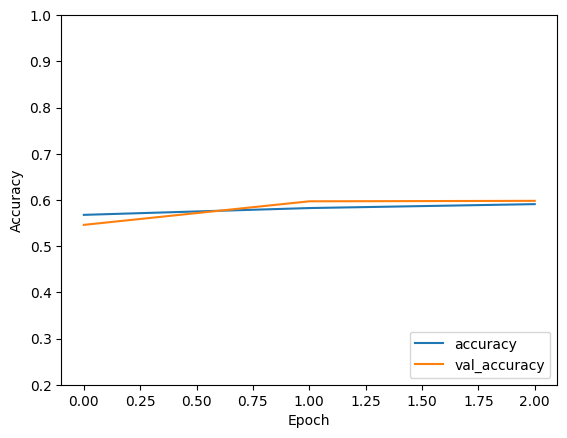

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_tf_test, verbose=2)


In [28]:
print(test_acc)


0.5649999976158142
